# Exploratory Data Analysis
Written by: Adam Li
Exploration of the dataset from https://github.com/Upward-Spiral-Science/data/tree/master/syn-diversity.

We are looking at the feature matrix and the location matrix.

In [1]:
# Import Necessary Libraries
import numpy as np
import os, csv, json

from matplotlib import *
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import scipy
from sklearn.decomposition import PCA
import skimage.measure

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
channel = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
           'psd','glur2','nmdar1','nr2b','gad','VGAT', 'PV','Gephyr',
           'GABAR1','GABABR','CR1','5HT1A', 'NOS','TH','VACht',
           'Synapo','tubuli','DAPI']

channeltype = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
               'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
               'in.pre','in.post','in.post','in.post','in.pre.small','other',
               'ex.post','other','other','ex.post','none','none']
print channel
print channeltype

['Synap', 'Synap', 'VGlut1', 'VGlut1', 'VGlut2', 'Vglut3', 'psd', 'glur2', 'nmdar1', 'nr2b', 'gad', 'VGAT', 'PV', 'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'tubuli', 'DAPI']
['ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'in.pre.small', 'ex.post', 'ex.post', 'ex.post', 'ex.post', 'in.pre', 'in.pre', 'in.pre', 'in.post', 'in.post', 'in.post', 'in.pre.small', 'other', 'ex.post', 'other', 'other', 'ex.post', 'none', 'none']


In [5]:
#### RUN AT BEGINNING AND TRY NOT TO RUN AGAIN - TAKES WAY TOO LONG ####
# load in the feature data
list_of_features = []
with open('data/synapsinR_7thA.tif.Pivots.txt.2011Features.txt') as file:
    for line in file:
        inner_list = [float(elt.strip()) for elt in line.split(',')]
        
        # create list of features
        list_of_features.append(inner_list)

# conver to a numpy matrix
list_of_features = np.array(list_of_features)

In [3]:
# load in volume data
list_of_locations = []
with open('data/synapsinR_7thA.tif.Pivots.txt') as file:
    for line in file:
        inner_list = [float(elt.strip()) for elt in line.split(',')]
        
        # create list of features
        list_of_locations.append(inner_list)

# conver to a numpy matrix
list_of_locations = np.array(list_of_locations)

## Missing Values?
* There are no missing values based on our csv read function
* These are all numbers

In [6]:
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in xrange(len(vec)):
        if item == vec[i]:
            return i
    return -1

min_location = []
max_location = []

x_range = list_of_locations[:, 0]
y_range = list_of_locations[:, 1]
z_range = list_of_locations[:, 2]

mins = [min(x_range), min(y_range), min(z_range)]
maxs = [max(x_range), max(y_range), max(z_range)]

# find min/max values and where they occur
min_location = [
    {min(x_range): find_first(min(x_range), x_range)},  
    {min(y_range): find_first(min(y_range), y_range)},
    {min(z_range): find_first(min(z_range), z_range)}
]
max_location = [
    {max(x_range): find_first(max(x_range), x_range)},  
    {max(y_range): find_first(max(y_range), y_range)},
    {max(z_range): find_first(max(z_range), z_range)}
]
# max_location = [max(x_range), max(y_range), max(z_range)]

# print some basic stats about the list of features and locations
print "The size of the feature matrix is: ", list_of_features.shape
print "The size of the location matrix is: ", list_of_locations.shape

print "min and max are:"
print mins
print maxs

# for i in range(0, len(min_location)):
#     print json.dumps(min_location[i], indent=4, separators=(',', ': '))
#     print json.dumps(max_location[i], indent=4, separators=(',', ': '))


The size of the feature matrix is:  (1119299, 144)
The size of the location matrix is:  (1119299, 3)
min and max are:
[28.0, 23.0, 2.0]
[1513.0, 12980.0, 40.0]


## Features 
f0 = integrated brightness 
f1 = local brightness 
f2 = distance to Center of Mass 
f3 = moment of inertia around synapse

Joshua says we can throw out f4 and f5?

Synapse Data:
* Excitatory presynaptic: ‘Synap’, ‘Synap’, ‘VGlut1’, ‘VGlut1’, ‘VGlut2’,
* Excitatory postsynaptic: ‘psd’, ‘glur2’, ‘nmdar1’, ’nr2b’, ’NOS’, ’Synapo’ (but further away than PSD, gluR2, nmdar1 and nr2b) 
* Inhibitory presynaptic: ‘gad’, ‘VGAT’, ‘PV’, 
* Inhibitory postsynaptic: ‘Gephyr’, ‘GABAR1’, ‘GABABR’, ’NOS’, 
* At a very small number of inhibitory: ‘Vglut3’ (presynaptic), ’CR1’(presynaptic), 
* Other synapses:‘5HT1A’, ‘TH’, ’VACht’, 
* Not at synapses: ‘tubuli’, ‘DAPI’.

In [30]:
# Create feature matrices for each feature f0,...,f5
f0_features = list_of_features[:, 24*0:24*(0+1)]
f1_features = list_of_features[:,24*1:24*(1+1)]
f2_features = list_of_features[:,24*2:24*(2+1)]
f3_features = list_of_features[:,24*3:24*(3+1)]
f4_features = list_of_features[:,24*4:24*(4+1)]
f5_features = list_of_features[:,24*5:24*(5+1)]

# create new list of features of just f0, f1, f2, f3
new_list_of_features = np.concatenate([f0_features, f1_features, f2_features, f3_features], axis=1)
new_list_of_features = np.array(new_list_of_features)

print "Each feature matrix represents"
print "Feature matrix for this certain metric is of size: ", f0_features.shape
print "The new list of features without f3 and f4 is size: ", new_list_of_features.shape

Each feature matrix represents
Feature matrix for this certain metric is of size:  (1119299, 24)
The new list of features without f3 and f4 is size:  (1119299, 96)


In [44]:
new_list_of_features = np.array(new_list_of_features)
# write new list_of_features to new txt file
csvfile = "data/synapsinR_7thA.tif.Pivots.txt.2011ShortenedFeatures.txt"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    # write to new file the data
    writer = csv.writer(output, lineterminator='\n')
    for row in range(0, len(new_list_of_features)):
        writer.writerow(new_list_of_features[row,:])

In [17]:
###### Create Volume Feature Vector ######
# 01: normalize
x_locations = list_of_locations[:,0]/max(x_range)
y_locations = list_of_locations[:,1]/max(y_range)
z_locations = list_of_locations[:,2]/max(z_range)

x_locations = np.reshape(np.array(x_locations), (len(x_locations),1))
y_locations = np.reshape(np.array(y_locations), (len(x_locations),1))
z_locations = np.reshape(np.array(z_locations), (len(x_locations),1))

locations = np.concatenate((x_locations, y_locations, z_locations), axis=1)
# 02: map onto 1 + 10 + 100
feature_location = x_locations + 10*y_locations + 100*z_locations

# end is a feature vector describing point in space

1119299


In [18]:
################### SAVE NORMALIZED LOCATION DATA ###################
# write new list_of_features to new txt file
csvfile = "data_normalized/locations_normalized.txt"

#Assuming res is a flat list
with open(csvfile, "w") as output:
    # write to new file the data
    writer = csv.writer(output, lineterminator='\n')
    for row in range(0, len(locations)):
        writer.writerow(locations[row,:])

## Histograms of each Column (X,Y,Z)
To determine the distributions of x,y,z coordinates, I want to plot the histograms and possibly violin plots to visualize.

Another good way of determining distributions of the features would be to plot a histogram of each 24 protein expressions in the 4 different feature metrics. 

Not sure what a good way of looking at this data is...

In [3]:
# load in volume data
list_of_locations = []
with open('../data_normalized/locations_normalized.txt') as file:
    for line in file:
        inner_list = [float(elt.strip()) for elt in line.split(',')]
        
        # create list of features
        list_of_locations.append(inner_list)

# conver to a numpy matrix
list_of_locations = np.array(list_of_locations)
print list_of_locations.shape

(1119299, 3)


In [4]:
# 01: normalize
x_locations = list_of_locations[:,0]
y_locations = list_of_locations[:,1]
z_locations = list_of_locations[:,2]

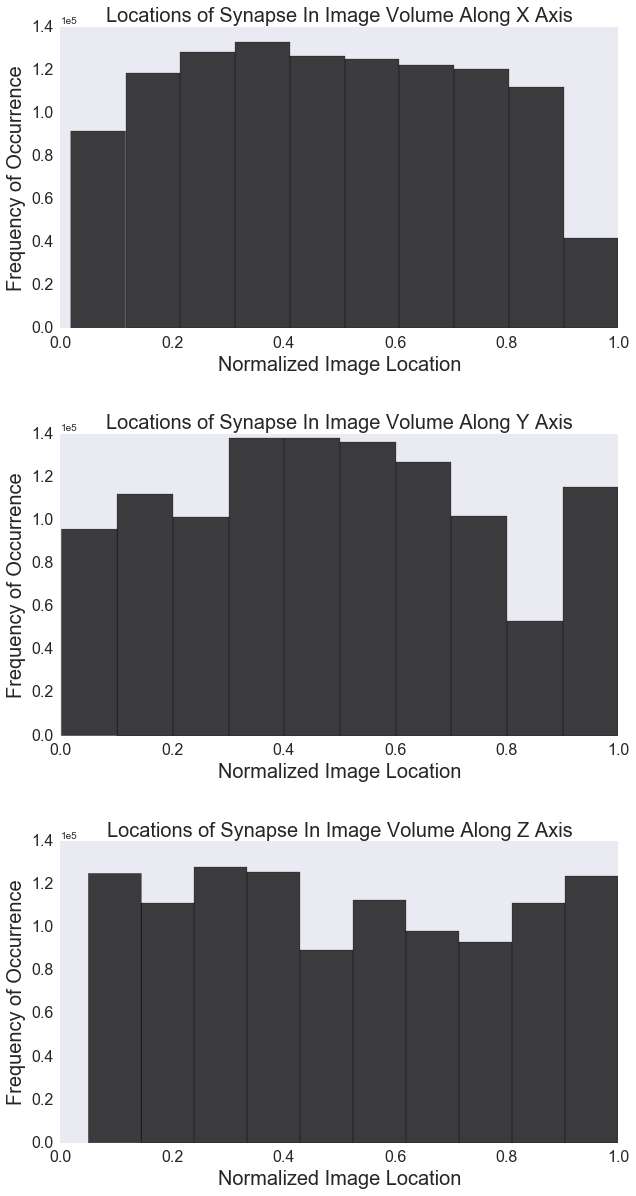

In [31]:
fig = plt.figure(figsize=(10,20))
fig.add_subplot(311)
plt.hist(x_locations, facecolor='black', alpha=0.75)
plt.subplots_adjust(hspace=0.35)
plt.title("Locations of Synapse In Image Volume Along X Axis", fontsize=20)
plt.grid(False)
plt.xlabel("Normalized Image Location", fontsize=20)
plt.ylabel("Frequency of Occurrence", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', scilimits=(0,0))

fig.add_subplot(312)
plt.hist(y_locations, facecolor='black', alpha=0.75)
plt.title("Locations of Synapse In Image Volume Along Y Axis", fontsize=20)
plt.grid(False)
plt.xlabel("Normalized Image Location", fontsize=20)
plt.ylabel("Frequency of Occurrence", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', scilimits=(0,0))

fig.add_subplot(313)
plt.hist(z_locations, facecolor='black', alpha=0.75)
plt.title("Locations of Synapse In Image Volume Along Z Axis", fontsize=20)
plt.grid(False)
plt.xlabel("Normalized Image Location", fontsize=20)
plt.ylabel("Frequency of Occurrence", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ticklabel_format(style='sci', scilimits=(0,0))


## Histograms of each Column For F0
To determine the distributions of x,y,z coordinates, I want to plot the histograms and possibly violin plots to visualize.

Data description from:
https://github.com/Upward-Spiral-Science/data/tree/master/syn-diversity

F0 is the feature metric of integrated brightness


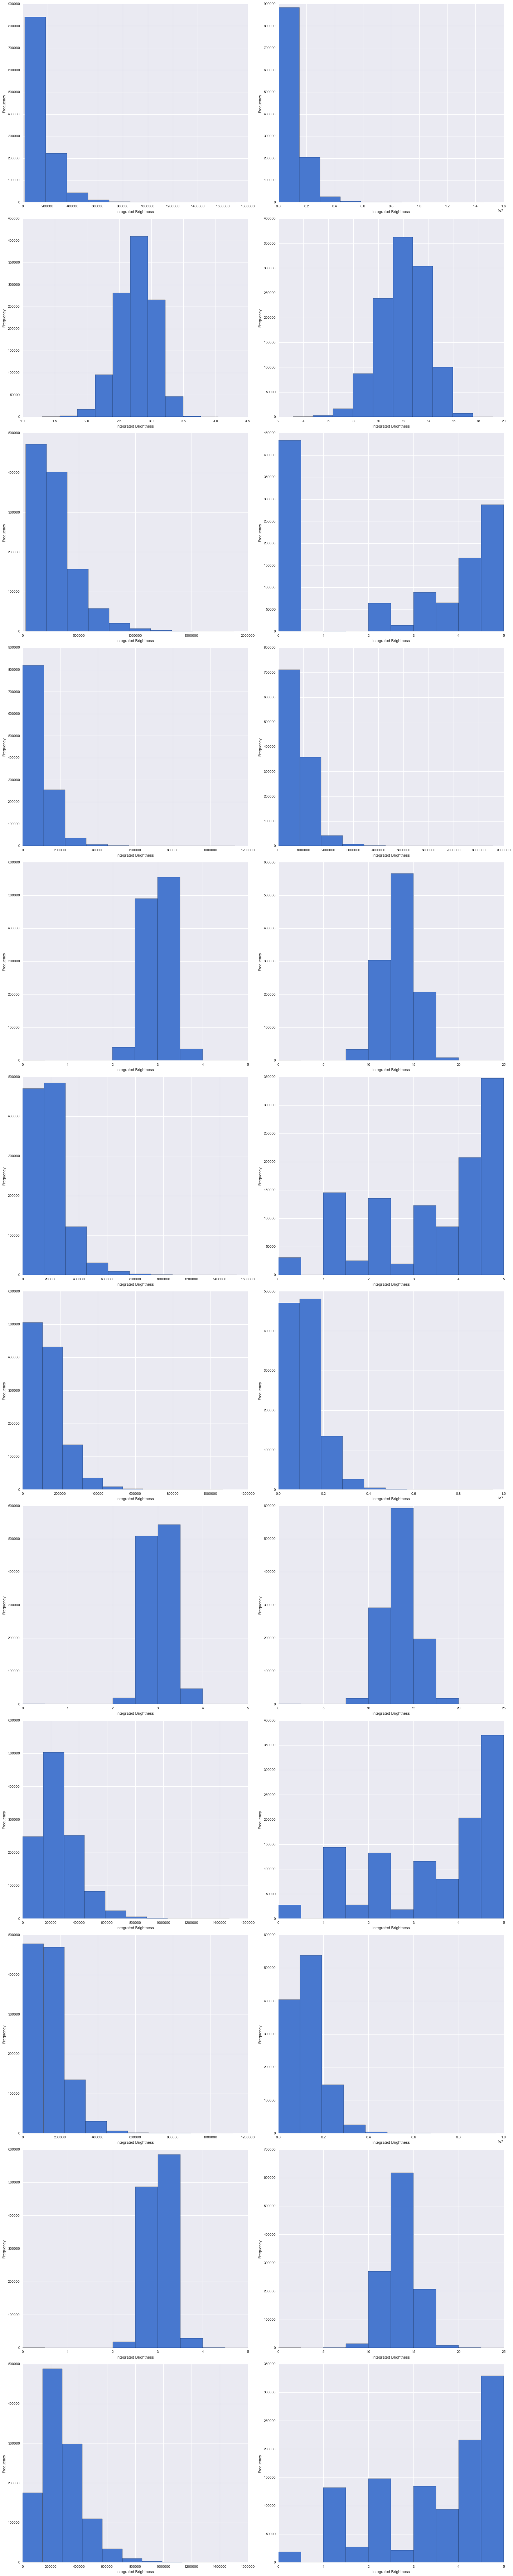

In [64]:
# create figure
fig = plt.figure(figsize=(20, 100))

width = f0_features.shape[1]
# loop through each 24 features for this specific metric
for i in range(0, width):
    feature = f0_features[:, i]
    fig.add_subplot(width/2, 2, i+1)
    plt.hist(feature)
#     plt.title("X Locations Histogram")
    plt.xlabel("Integrated Brightness")
    plt.ylabel("Frequency")
    
plt.tight_layout()